In [18]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deilton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Carregando os dados e ordenando-os

In [19]:
file_name = 'data.pkl'

# Carregar o DataFrame usando pickle
with open(file_name, 'rb') as file:
    df = pickle.load(file)

# Ordenar o dataset de acordo com a temporada e episódio em ordem cronológica
df = df.sort_values(by=['season_number', 'episode_number'])
df.head(5)

title  season_number  episode_number  \
177               Prisoners of Love              1               3   
185          Ricardio the Heart Guy              1               7   
34                    Business Time              1               8   
155          My Two Favorite People              1               9   
148  Memories of Boom Boom Mountain              1              10   

                                                  text  \
177  [{'origin': 'action', 'text': '[The episode st...   
185  [{'origin': 'action', 'text': '[The episode be...   
34   [{'origin': 'action', 'text': '[The episode be...   
155  [{'origin': 'action', 'text': '[Finn and Jake ...   
148  [{'origin': 'action', 'text': '[The episode st...   

                              directors                            writers  
177  [Larry Leichliter, Patrick McHale]        [Pendleton Ward, Adam Muto]  
185  [Larry Leichliter, Patrick McHale]          [Bert Youn, Sean Jimenez]  
34   [Larry Leichliter, Patrick McHale]  [Luther McLaurin, Armen Mirzaian]  
155  [Larry Leichliter, Patrick McHale]     [Pendleton Ward, Kent Osborne]  
148  [Larry Leichliter, Patrick McHale]          [Bert Youn, Sean Jimenez]

In [5]:
df.tail(5)

title  season_number  episode_number  \
146      Marcy & Hunson             10               7   
23             Blenanas             10               9   
124  Jake the Starchild             10              10   
92            Gumbaldia             10              12   
42   Come Along With Me             10              13   

                                                  text  \
146  [{'origin': 'Peppermint Butler', 'text': 'Swor...   
23   [{'origin': 'action', 'text': '[The episode op...   
124  [{'origin': 'action', 'text': '[The episode op...   
92   [{'origin': 'action', 'text': '[The episode op...   
42   [{'origin': 'action', 'text': '[Outside a very...   

                              directors  \
146                      [Cole Sanchez]   
23                     [Diana Lafyatis]   
124                      [Cole Sanchez]   
92                     [Diana Lafyatis]   
42   ["Cole Sanchez", "Diana Lafyatis"]   

                                               writers  
146                           [Graham Falk, Adam Muto]  
23                         [Patrick McHale, Sam Alden]  
124                 [Aleks Sennwald, Hanna K. Nyström]  
92                            [Sam Alden, Graham Falk]  
42   ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...

## Análise de distribuição dos episódios

O _dataset_ não contém todos os episódios da série. Assim, vale analisarcomo os episódios presentes estão distribuídos. A célula a seguir conta quantos episódios constam no dataset para cada temporada.

In [20]:
df.season_number.value_counts().sort_index()

1     15
2     14
3     18
4     20
5     34
6     30
7     20
8     22
9      8
10     8
Name: season_number, dtype: int64

A diferença é muito grande, no entanto, esta animação não possui a mesma quantidade de episódios em cada temporada, existindo uma grande variação no tamanho de cada uma delas. A célula a seguir normalizará esse fator, calculando a proporção de episódios de cada temporada que está presente no dataset.

In [21]:
season_lengths = [26, 26, 26, 26, 52, 43, 26, 27, 14, 16]

for i, length in enumerate(df.season_number.value_counts().sort_index()):
    # No caso da décima temporada, o episódio "Come Along with Me" foi dividido em 4 atos, e assim, 
    # para balancear isto, soma-se 3 à quantidade de episódios desta temporada no dataset.
    n = length + 3 if i == 9 else length
    
    proportion = (n * 100) / season_lengths[i]
    
    print(f"{i + 1}a temporada: {proportion:.2f}% ({n} episódios de {season_lengths[i]})")

total_episodes = 282
proportion = ((len(df) + 3) * 100) / total_episodes
print(f"Total: {proportion:.2f}% ({len(df) + 3} episódios de {total_episodes})")

1a temporada: 57.69% (15 episódios de 26)
2a temporada: 53.85% (14 episódios de 26)
3a temporada: 69.23% (18 episódios de 26)
4a temporada: 76.92% (20 episódios de 26)
5a temporada: 65.38% (34 episódios de 52)
6a temporada: 69.77% (30 episódios de 43)
7a temporada: 76.92% (20 episódios de 26)
8a temporada: 81.48% (22 episódios de 27)
9a temporada: 57.14% (8 episódios de 14)
10a temporada: 68.75% (11 episódios de 16)
Total: 68.09% (192 episódios de 282)


o dataset conta com quase 70% dos episódios da série, e a distribuição tem pelo menos 53.85% dos episódios na temporada com menor cobertura (a segunda) e 80.77% na de maior cobertura (a sétima).

## Identificando relevância de personagens

Nesta sessão, serão feitas algumas análises para criar algumas medidas da relevância dos personagens. Para isto, faremos uso da maneira como as transcrições estão organizadas.

Cada transcrição de episódio corresponde a uma lista de dicionários, sendo cada dicionário na forma

```
{
    "origin": "Origem da fala. Aqui é identificado quem foi o locutor, ou, caso seja uma ação do ambiente, será identificado apenas como 'action'."
    "text": "O texto em si da transcrição."
}
```

Aproveitando-se desta organização, diversas perguntas podem ser respondidas. A seguir, será calculado quantos personagens existem ao longo da série.

In [22]:
unique_origins = np.unique(np.concatenate(df['text'].apply(lambda lst: [d['origin'] for d in lst])))

In [5]:
print(f"Total: {len(unique_origins)} personagens")

for n in unique_origins:
    print(n)

Total: 1097 personagens

(Gob, Grob, or Grod)­
-
A voice
A voice in the distance
A weekend survivalist­
A worm
Ab Demon
Abracadaniel
Achillea
Alarm
Alarm clock with a headshot of Princess Bubblegum taped to the minute hand
Alien
Alien 1
Alien 2
Alien groom
Aliens
All
All Knights
All demons
Alpha Hug Wolf
Amazonia
Ancient Psychic Tandem War Elephant
Ancient Sleeping Magi of Life Giving
Ann
Another Banana Guard
Another Candy Person
Another hooligan
Ant
Antelope
Apple Merchant
Apples
Ariel
Armadillo
Ash
Astral Mr. Fox
Audience
Audience member
Automated female voice
BMO
BMO & Bubble
BMO [As Ronnie, deeper voice]
BMO [As Ronnie]
BMO [as Bebe]
BMO [as Lorraine]
BMO [as Officer Davis]
BMO [flashback]
BMO [in its thoughts]
BMO [narrating]
Baby
Baby Cuber
Baby Finns
Baby Snaps
Balthus
Banana Guard
Banana Guard #1
Banana Guard #2
Banana Guard 1
Banana Guard 2
Banana Guard 500
Banana Guard I
Banana Guard II
Banana Guard Leader
Banana Guard Number 3
Banana Guard [in Finn's memory]
Banana Guard [ov

No total, existem mais de 1000 origens de fala diferente. Mesmo considerando que isto inclui a origem "_action_" discutida antes e outros casos especiais como personagens falando em uníssono, ainda é uma quantidade muito grande de personagens para se analisar individualmente. Com isso, é importante encontrar maneiras de se identificar personagens mais relevantes. 

### Quantidade de falas

Uma medida de relevância pode ser a quantidade de falas que um personagem tem ao longo da série. Personagens com mais falas provavelmente têm mais tempo de tela e portanto têm mais chances de serem relevantes. A célula a seguir encontra todos os personagens e conta quantas falas cada um deles têm.

In [23]:
def count_character_lines_per_episode(character, row):
    amt = 0
    for line in row['text']:
        if character == line['origin']:
            amt += 1
    return amt

def get_character_lines_amount(character, dataframe):
    amt = 0
    for i in range(len(dataframe)):
        amt += count_character_lines_per_episode(character, dataframe.loc[i])
    return amt

def make_character_lines_dataframe(characters, dataframe):
    chars_dict = {
        'character name': [],
        'lines': []
    }

    for char in characters:
        # Um dos nomes de origem ficou como "-", mas isso se dá por causa de uma transcrição incompleta no material de origem.
        # Para evitar que ela apareça na listagem, mas sem perder o texto do episódio, que pode ser útil para a análise, 
        # a condição a seguir é adicionada.
        if char == "-":
            continue
        chars_dict['character name'].append(char)
        chars_dict['lines'].append(get_character_lines_amount(char, dataframe))
    
    chars_dict = pd.DataFrame(chars_dict)
    return chars_dict.sort_values(by=['lines'], ascending=False)

chars_lines_df = make_character_lines_dataframe(unique_origins, df)
chars_lines_df.head(31)

character name  lines
1072                action   8940
319                   Finn   4826
518                   Jake   3775
500               Ice King    769
796     Princess Bubblegum    732
38                     BMO    607
646              Marceline    525
626   Lumpy Space Princess    389
995            Tree Trunks    239
363                 Fionna    153
384         Flame Princess    145
323            Finn & Jake    110
581         Lady Rainicorn    105
468                 Gunter     92
774      Peppermint Butler     90
574            King of Ooo     84
342          Finn and Jake     81
886         Simon Petrikov     81
815                 Prismo     80
594              Lemongrab     75
923                Starchy     71
140                   Cake     67
550               Jermaine     65
494         Hunson Abadeer     63
880                 Shelby     60
937                Sweet P     59
223             Cosmic Owl     58
718                  Neptr     58
896         Slime Princess     58
53            Banana Guard     57
196           Cinnamon Bun     56

Para facilitar a visualização, o gráfico a seguir compara as quantidades

In [26]:
data = chars_lines_df.iloc[1:31]

fig = px.bar(data, x='character name', y='lines')

fig.update_layout(
    xaxis_title="Personagem",
    yaxis_title="Quantidade de falas"
)
fig.show()

Para a visualização acima foi descartada a coluna de "_action_" para melhorar a escala. Ainda assim, como esperado, os personagens com maior quantidade de linhas são os protagonistas, Finn e Jake. Vale mencionar alguns pontos, no entanto.

+ O Rei Gelado (_Ice King_, no _dataset_) e o Simon, são na verdade o mesmo personagem após passar por uma transformação
+ _Banana Guard_ (Em português, Guarda Banana) refere-se a um grupo de personagens, que compõem um conjunto de guardas. Considerando-se isso, É possível que eles não sejam tão relevantes quanto a sua posição aqui sugere.
+ Existem posições como "Finn and Jake" e "Finn & Jake", que se referem a falas que a dupla teve simultaneamente. PAra fins desta análise, essas serão consideradas sempre que qualquer um dos dois for analisado, e não individualmente.

### Quantidade de aparições

Uma outra maneira de se medir a relevância de um personagem é medir a quantidade de episódios diferentes em que ele aparece. Isso porque personagens mais recorrentes na trama podem ser considerados mais importantes. A célula a seguir calcula em quantos episódios cada um dos personagens apareceu e teve ao menos uma fala.

In [7]:
def is_character_on_episode(character, row):
    for line in row['text']:
        if character == line['origin']:
            return True
    return False

def get_character_showings(character, dataframe):
    amt = 0
    for i in range(len(dataframe)):
        if is_character_on_episode(character, dataframe.loc[i]):
            amt += 1
    return amt

def make_character_showings_dataframe(characters, dataframe):
    chars_dict = {
        'character name': [],
        'showings': []
    }

    for char in characters:
        # Um dos nomes de origem ficou como "-", mas isso se dá por causa de uma transcrição incompleta no material de origem.
        # Para evitar que ela apareça na listagem, mas sem perder o texto do episódio, que pode ser útil para a análise, 
        # a condição a seguir é adicionada.
        if char == "-" or char == "":
            continue
        chars_dict['character name'].append(char)
        chars_dict['showings'].append(get_character_showings(char, dataframe))
    
    chars_dict = pd.DataFrame(chars_dict)
    return chars_dict.sort_values(by=['showings'], ascending=False)

chars_showings_df = make_character_showings_dataframe(unique_origins, df)
chars_showings_df.head(31)

character name  showings
1092                action       191
324                   Finn       163
526                   Jake       155
37                     BMO        63
808     Princess Bubblegum        61
508               Ice King        50
347          Finn and Jake        40
328            Finn & Jake        36
657              Marceline        26
636   Lumpy Space Princess        25
475                 Gunter        17
52            Banana Guard        17
786      Peppermint Butler        15
1012           Tree Trunks        14
590         Lady Rainicorn        14
199           Cinnamon Bun        12
938                Starchy        12
389         Flame Princess        10
64           Banana Guards        10
894                 Shelby         9
113                   Both         9
911         Slime Princess         8
731                  Neptr         8
648                    Man         8
15                     All         7
1043                 Voice         7
603              Lemongrab         7
1020       Turtle Princess         7
1065    Wildberry Princess         7
158           Candy People         6
898                  Simon         6

In [12]:
data = chars_showings_df.iloc[1:31]

fig = px.bar(data, x='character name', y='showings')
fig.show()

É possível identificar-se algumas diferenças com relação à métrica anterior. Os protagonistas ainda estão em primeiro e segundo lugar, no entanto alguns personagens que não apareciam na visualização anterior estão presentes nessa, e _vice versa_. Além disso, pode-se fazer outras considerações:

+ De forma análoga a Ice King (Rei Gelado) e Simon, Os personagens Gunter e Orgalorg são o mesmo personagem em formas diferentes.
+ Algumas origens nesta visualização se referem a termos muito genéricos e que por conta disso estão presentes em diversos episódios sem contudo ter relevância. Alguns exemplos disso são Voice (voz), Man (Homem), All (Todos, relativo a quando todos os personagens em cena falam), Both (Ambos) e Banana Guard(s)

### Quantidade de menções

Adicionalmente, um personagem relevante pode ser um personagem com mais impacto ou interação com os demais. Uma forma de medir isto é verificando quais são os personagens sobre o qual outros personagens falam com alguma frequência. As células a seguir calculam quantas menções cada personagem recebeu ao longo da série.

In [8]:
# Alguns Personagens possuem nomes muito comuns ou que são substrings de outros. Isto atrapalharia a análise e portanto esta função atuará como uma lista para ignorar estes personagens por ora.
def get_common_character_names():
    return ['Princess', 'Man', 'Well', 'Marc', 'People', 'Bubble', 'Guard', 'All', 'Lady', 'Tree', 'Flame Prince', 'Guy', 'Baby', 'Lumpy Space Prince']

def get_aliases(character):
    aliases_dict = {
        'Princess Bubblegum': ['Bonnie', 'Bonny', 'PB', 'Bonnibel', 'Peebs'],
        'Marceline': ['Marcy'],
        'Flame Princess': ['FP'],
        'Gunter': ['Gunther'],
        'Lumpy Space Princess': ['LSP'],

    }
    try:
        aliases = aliases_dict[character]
        aliases.append(character)
    except:
        aliases = [character]
    return aliases

def is_mentioned(character, text):
    aliases = get_aliases(character)
    mention = False
    for alias in aliases:
        if alias in text and text != 'action'and text != character:
            mention = True
    return mention

def count_character_mentions_per_episode(character, row):
    amt = 0
    for line in row['text']:
        if is_mentioned(character, line['text']):
            amt += 1
    return amt

def get_character_mentions_amount(character, dataframe):
    amt = 0
    for i in range(len(dataframe)):
        amt += count_character_mentions_per_episode(character, dataframe.loc[i])
    return amt

def make_character_mentions_dataframe(characters, dataframe):
    chars_dict = {
        'character name': [],
        'mentions': []
    }

    for char in characters:
        # Um dos nomes de origem ficou como "-", mas isso se dá por causa de uma transcrição incompleta no material de origem.
        # Para evitar que ela apareça na listagem, mas sem perder o texto do episódio, que pode ser útil para a análise, 
        # a condição a seguir é adicionada.
        if char == "-" or char == "" or char in get_common_character_names():
            continue
        chars_dict['character name'].append(char)
        chars_dict['mentions'].append(get_character_mentions_amount(char, dataframe))
    
    chars_dict = pd.DataFrame(chars_dict)
    return chars_dict.sort_values(by=['mentions'], ascending=False)

chars_mentions_df = make_character_mentions_dataframe(unique_origins, df)
chars_mentions_df.head(31)

character name  mentions
321                  Finn      3582
520                  Jake      3003
344         Finn and Jake       674
36                    BMO       617
502              Ice King       605
796    Princess Bubblegum       495
647             Marceline       408
628  Lumpy Space Princess       238
470                Gunter       206
385        Flame Princess       205
999           Tree Trunks       187
543                 James       137
365                Fionna       120
74                    Bee        99
553              Jermaine        97
886                 Simon        91
608                  Lich        88
50           Banana Guard        86
136                  Cake        84
427                  Glob        78
81                  Betty        76
196          Cinnamon Bun        71
972                   Tim        68
88                  Billy        67
942               Sweet P        66
458               Gumbald        66
596             Lemongrab        65
304              Everyone        64
600             Lemonhope        64
437                Goliad        64
583        Lady Rainicorn        63

In [14]:
data = chars_mentions_df.iloc[:30]

fig = px.bar(data, x='character name', y='mentions')
fig.show()


+ Como nos casos Ice King/Simon e Gunter/Orgalorg, O personagem Lich e Sweet P são o mesmo personagem, mas com uma transformação entre eles grande o suficiente que também podem ser considerados como outro.

Posto isso, encontra-se ainda os protagonistas nos rankings mais altos e personagens conhecidos próximos deles.

> Para todas estas métricas, no entanto, nota-se um favorecimento para personagens mais "antigos". Aqueles que foram introduzidos mais tarde na trama acabam recebendo pontuações menores ainda que tenham relevância para a história.

## Considerando os vocabulários

Nesta seção, O código focará a produção de visualizações e análises considerando os vocabulários da série em si e também de diferentes recortes, sejam de personagens ou de de temporada.

### Ponto de partida: O vocabulario da animação

Antes de mais nada, vale considerar o vocabulário geral da série. Para isto, podemos acessar a coluna de `text` do _dataframe_ e usar o texto das falas de personagens para montar um vocabulário com tudo o que foi dito nos episódios transcritos. A célula a seguir se encarregará disso.

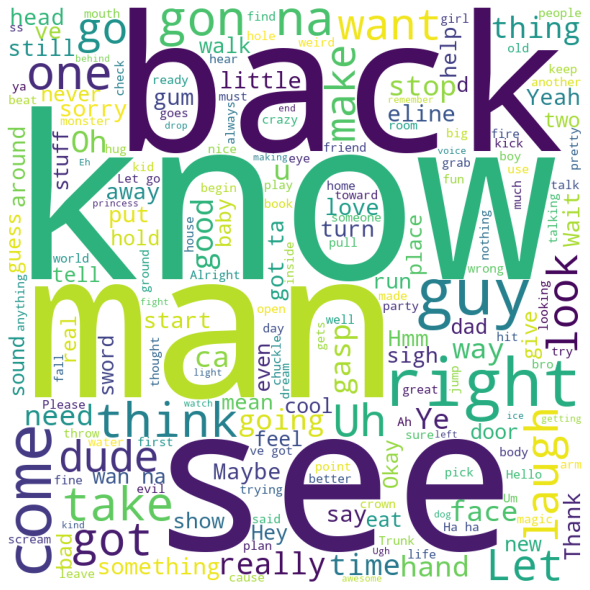

In [19]:
def get_stop_words():
    stop_words = set(stopwords.words('english'))
    custom_stop_words = {'\'s', '\'m', 'n\'t', 'oh', 'yeah', '\'re', 'look', '\'ll', 'okay', 'hey', 'aah', 'heh', 'wow', 'huh', 'whoa'}
    stop_words.update(custom_stop_words)
    return stop_words

def get_text(dataframe, characters=[]):
    text = ''
    for i in range(len(dataframe)):
        episode = dataframe.iloc[i]
        episode_text = "".join([line['text'] if line['origin'] != 'action' else '' for line in episode['text']])
        text += episode_text + ' '
    # Removing character names from the text
    for char in characters:
        text = text.replace(char, '')
    return text

text = get_text(df, unique_origins)

words = nltk.word_tokenize(text)

stop_words = get_stop_words()

filtered_words = [word for word in words if word.lower() not in stop_words]

text = ' '.join(filtered_words)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

### Para comparação: O vocabulário das temporadas

Além disso, pode-se ver o vocabulário de cada uma das temporadas. A seguir, duas _wordclouds_ são plotadas com os vocabulários da primeira e última temporadas, respectivamente.

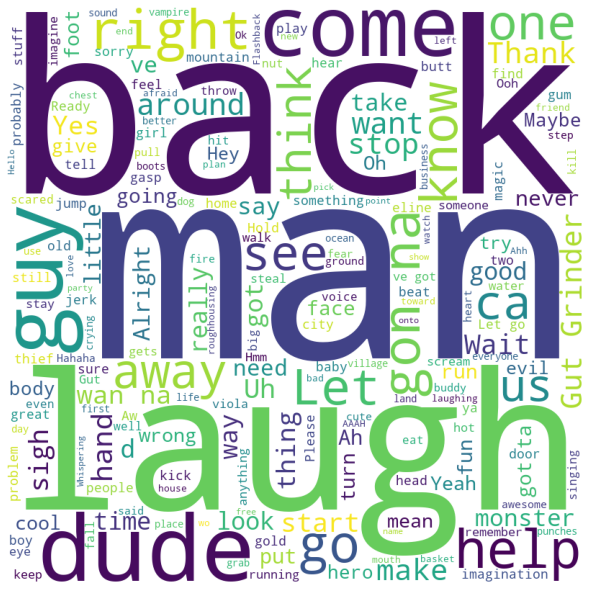

In [10]:
def plot_cloud_season(season_number):
    text = get_text(df.loc[df['season_number'] == season_number], unique_origins)

    words = nltk.word_tokenize(text)

    filtered_words = [word for word in words if word.lower() not in stop_words]

    text = ' '.join(filtered_words)

    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

plot_cloud_season(1)

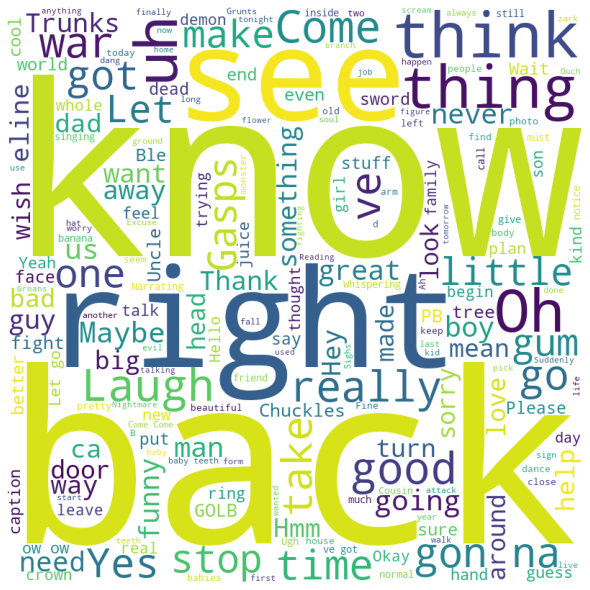

In [11]:
plot_cloud_season(10)

Ambas são muito semelhantes à nuvem geral (todas as temporadas) e também entre si. Isto sugere que o vocabulário não mude tanto assim ao longo das temporadas da série, ou pelo menos que muitas palavras mais comuns se repetem muito. Esta hipótese faz sentido por se tratar de um desenho com crianças como público alvo, é de se esperar que o vocabulário seja um pouco menos diverso.

### Ficando mais específico: O vocabulário dos personagens

Em seguida, ainda tratando-se de vocabulários, pode-se analisar se e como o vocabulário muda de um personagem para outro. A célula a seguir implementa a lógica de se obter todo o texto rotulado como de um determinado personagem no _dataset_.

                                               Oooh...[Interested] Oooh...[Gasps and scowls]Hmmm...[Applauds and sighs with admiration]I'm so happy! I'm so happy to meet you, Prince. You're my Prince. [ embraces Fake Finn.]Stop whispering! [ transforms to her enraged form and turns the other citizens of the Fire Kingdom into flambits.]We're... what?You... WHAT?! [ transforms again to her enraged form.][Screams of pain]You! What's wrong with me, huh?! You don't like me?!What's wrong with you?!Don't ever mess with me again! Don't ever mess with me again!Oh.[Gasps]Aaahh![Gasps]Huh?Ah!Ow!Yes! That's all you've done! [gasps] Are you trying to hurt me?! Is that why you're following me?![Gasps then runs away]I am ambushing you! [Throws fireball]Huh? Why do you torment me?I... [Smiles, blushes and glows brightly]Rggh! Enough. You should not toy with the emotions of a fire elemental.You told me you liked me, and you made my flame grow brighter, but then you put me out, which hurt! [Throws a big

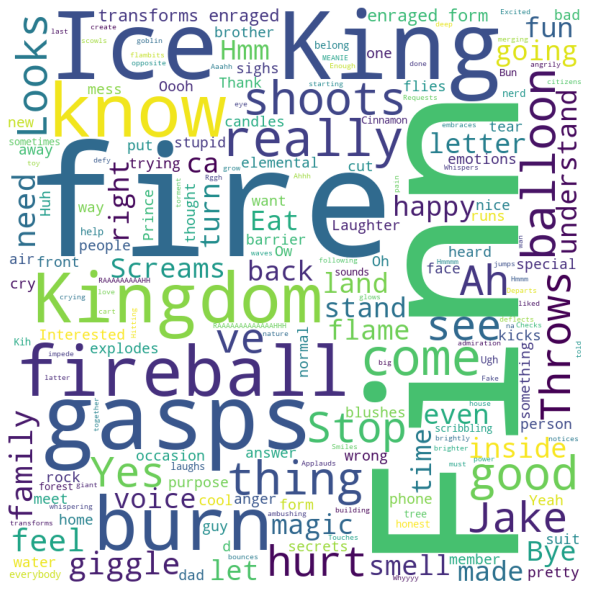

In [17]:
def get_character_text(character, dataframe):
    text = ''
    for i in range(len(dataframe)):
        episode_text = get_character_episode_text(character, dataframe.iloc[i])
        text += ' ' + episode_text.strip()
    return text

def get_character_episode_text(character, episode):
    episode_text = ''
    for line in episode['text']:
        if character in line['origin']:
            episode_text += line['text'].strip()
    return episode_text

def plot_character_wordcloud(character, dataframe):
    text = get_character_text(character, dataframe)
    

    stop_words = get_stop_words()
    
    text = text.replace(character, '')
    print(text)
    words = nltk.word_tokenize(text)
    
    filtered_words = [word for word in words if word.lower() not in stop_words]

    text = ' '.join(filtered_words)

    wordcloud = WordCloud(width=400, height=800, background_color='white').generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

plot_character_wordcloud('Flame Princess', df)

  Huh? Hee hee hee!What a patoot. Thanks for saving the day yet again, boys.I'm gonna throw you two a party. Meet at the Candy Kingdom—TONIGHT!Greetings, party-goers! Glad you could all make it!Whoa! No, I haven't! [Music starts up; crowd moves to the dance floor.] Wanna continue this conversation on the dance floor?Wow! That would mean that the babylons would fluctuate with the piranha-nanosphere!Oh, uh... Alright! [To Finn] Finn, what the cabbage? I was learning about Zanoits!Zanoits kill hundreds of thousands of Plantoids a year.Plantoids produce mellotoxin! [Finn stares.] Mellotoxin kills Zanoits!![Changing the subject] You're totally jealous of Ricardio.That's jealousy, hun.[Gasps] What's going on here?Ricardio?!Finn... why'd you do it?These were for our balbaflonic laser.Finn... you shouldn't punch brainiacs. You know how fragile they are! You gotta stop this jealous business.C'mon, Ricardio. I'll patch you up and give you candy. [They exit.]Finn!! Jake!!Finn! I feel like a big i

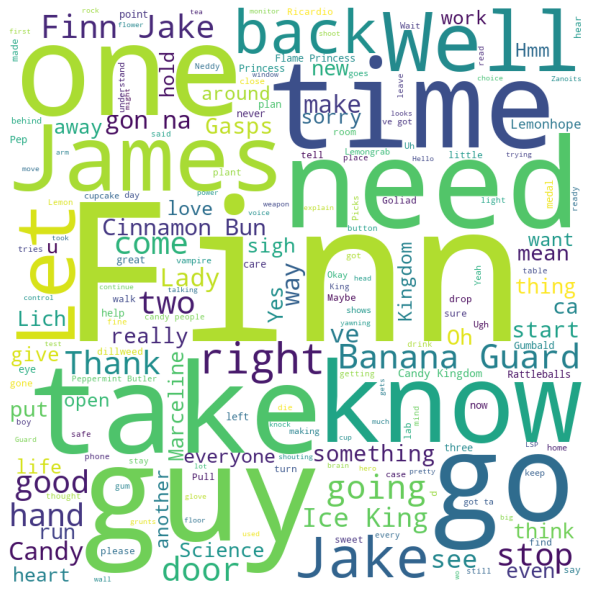

In [13]:
plot_character_wordcloud('Princess Bubblegum', df)

 Oh, no, our sled's broken! Hey, let's build one out of snow! [Starts to gather snow]What are you doing, Jake?Okay! [Jumps onto his gut and they slide down a hill][Frozen] Switch back! Switch back! [Jake grows and they switch again as they slide through a horde of penguins]Penguins!Ha Ha!Aww, Ice King's here.Oh ho oh! Holy cow!Yeah! There's a big sleeping lava man in our front yard, and he is SOOOOOOOOOOOO hot!Wait, wait, no, I take it back. I mean, not like "sexy" hot.No, I mean--[Sighs] Why don't you just try being cool.[Laughs]Heh heh, yeah.Huh, Wildberry Princess? Hot Dog Princess? W-what's goin' on?Ice King!Why are you keeping these girls prisoners, jerk?Ice King, don't do this. Just let the girls go. They don't want to be here.[Sighs] Don't worry, princesses. I pledge that Jake and I will protect each and everyone of you and furthermore I see all of you happily married to whatever sweet thing y'all want to be married to!Rad! All I need is something to spear the Ice King with. [Be

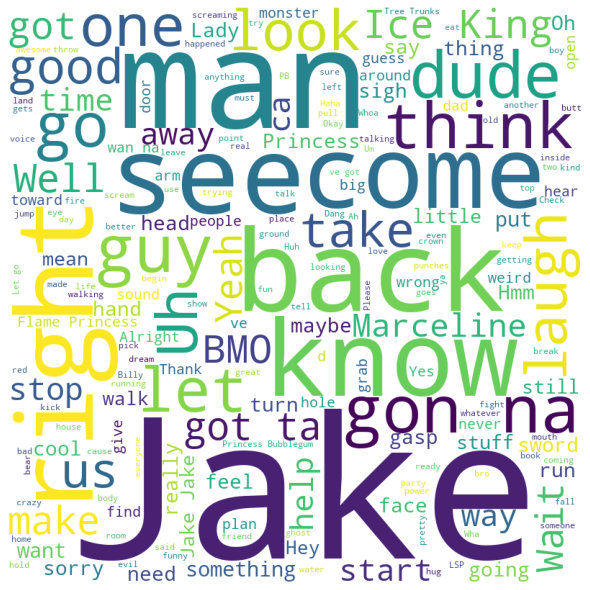

In [20]:
plot_character_wordcloud('Finn', df)

 Sleds are for suckers. Just ride on my gut.Switch!I'm a flying dog! [They fist tap in midair]Yeah, I know what "Ice King" means: A big nerd!Come on, brother! We're just trying to beat the heat.Mmm-hmm!No, no, you do mean "sexy" hot.Uh oh.Yeah, right, sure.Well, why'd you capture six of them if you just want to marry one?Aw, nuts, dude! You broke it when we tried picking the lock to that sad ogre's heart!Don't worry, Finn. I'll get us out of here with Key Hand! Hah-hah! [Uses Key Hand][Frozen] I... I'm okay.Finn!I'm fine, buddy. Calm down and tend to the princesses.What are you thinking, Finn?SweetSweet plan, dude!Because they like it here. Because they like you. Because you're a really fun guy!Whoa, whoa, whoa, Finn, what are you doing? Don't dump the Ice King on me!Oh, eh... Slime Princess, you shouldn't marry Finn. He pees his pants constantly. All the time. That paper crane for Princess Bubblegum?Heh. I bet you wish you were my butt.I bet you wish you were my butt, because then the

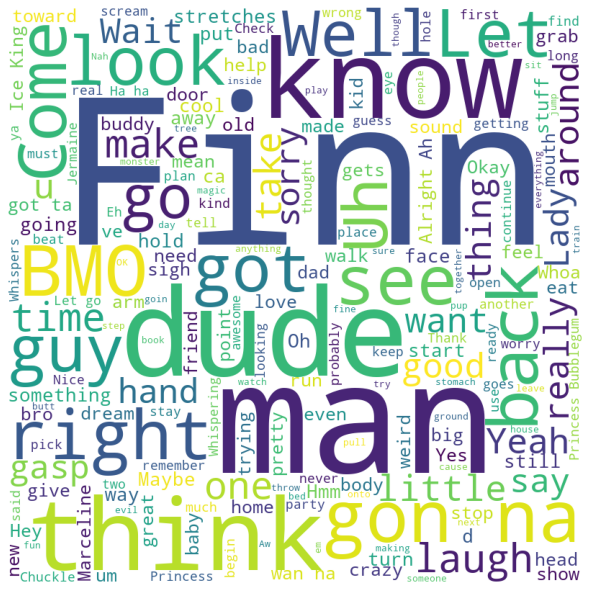

In [21]:
plot_character_wordcloud('Jake', df)

           I am incapable of all emotion.... but you are making me chafed!!  Who wants to play video games??I've created a new game called Conversation Parade.[singing] What do you think about the stars in the sky?That is an interesting response! Battery low... Shut doooowwwwn...        Yes, please.[Moving arms up] Ahh... Oh no! It's much more dangerous than you think!Yes, of course, Jake. [opens compartment on self] If I push this button-If I push this button, you will both be dangerously transported into my main brain game frame where it is very dangerous!No! It's a far too dangerous incredible adventure for you! It's final.[The hole Jake and Finn came out of is start shooting out blue electric current.] Did you have to- oh no! Wait! Run!Help! Oh no!I can't, Finn! I'm stuck!They're too strong! Use the combo move, Finn! The combo- [Hunny Bunny drenches  in honey so he cannot finish his sentence.]Finn, I told you about the danger! And now look! You fricasseed my stuff and broke our hou

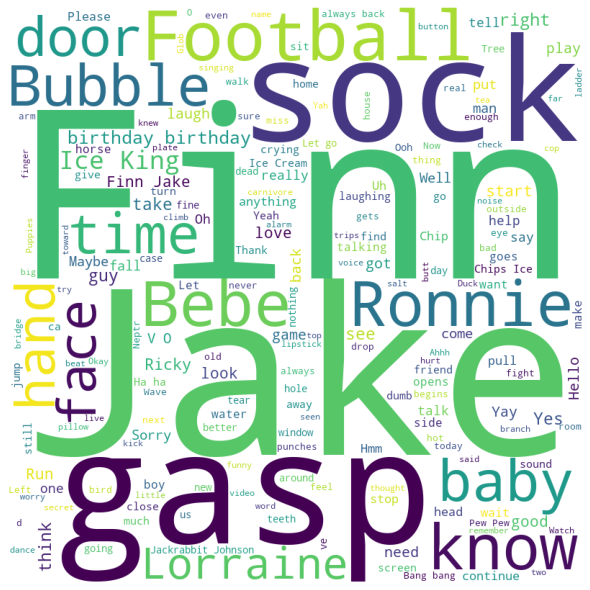

In [22]:
plot_character_wordcloud('BMO', df)

      Hey, guys. What's up? I'm  the Vampire Queen.[laughing] Calm down, weenies. I'm not gonna do that. [Lights candles]Sometimes, I do. But it's not the blood that I like. It's the color. I eat shades of red.Ugh, I am exhausted. I've been traveling all over the Land of Ooo. And I've seen some stuff that would really make you say "like what?"I encountered a school of goldfish beasts. [A flashback of  riding giant goldfish]And I fooled around in the Fire Kingdom. [A flashback of  hula-hooping in the Fire Kingdom]Oh, and check these out. [She has nuts in her hands]Oh, these aren't ordinary nuts. [Squeezes the nuts and they become little creatures. One squirts Finn with ink.]You guys seem cool, too, but as you can imagine, I'm really tired, so you two should probably get going.[sighs] Look. [She uses psychokinesis and moves a picture frame and reveals an "M" carved into the tree] "M" for "."I carved in this tree years ago. Way before you two rascals started squatting here. [Flings them o

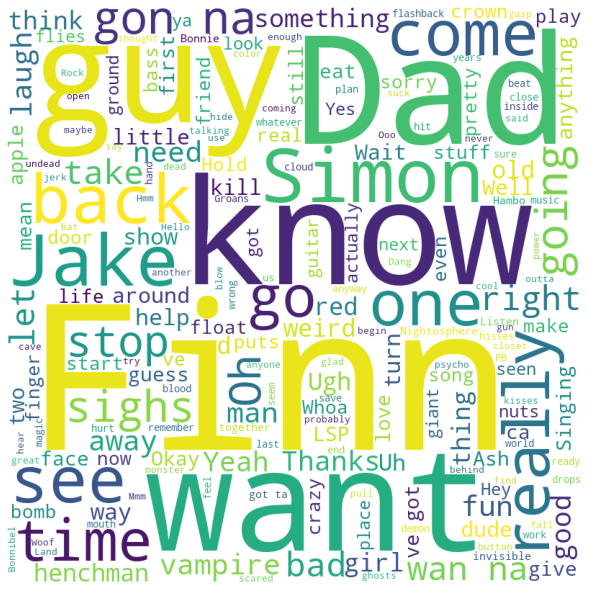

In [23]:
plot_character_wordcloud('Marceline', df)

Pode-se per

 What?! [Approaches the crater] Who dares enter the dom?!You know why I'm here? Do you know what "" means?!It means I'm King of Ice! This is my domain! And you are violating Ice World law--trespassing![Annoyed] I don't care! This is my kingdom. You guys can't just scoot about on my land willy-nilly. I've got rules here.[Flips out] What?! I am the king! I am the king of c-cool c-co ca... That's it! Rise, monsters of snow, and go beat up Finn and Jake! [Uses magic to bring out snow monsters][Angry] Ooh, you guys are gonna get it.[Groans] I need a magic back. [Cracks his back and pulls out a plastic sandwich bag] Trail mix. [Begins to pick around in it] Ick...ooh, yogurt chip. [Eats yogurt chip and puts the bag away] Tuck, tuck. [Begins to push the wheelbarrow again] Aww man.I'm back home! Hello, ladies!Now, now. I've brought you a baby and a puppy. [Tosses Finn and Jake into the room, where they smash against the wall and are freed from the ice]What?You don't understand! I collect prince

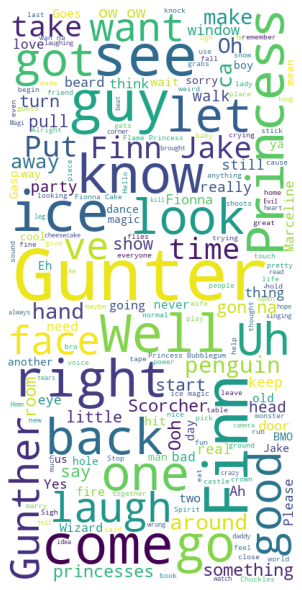

In [15]:
plot_character_wordcloud('Ice King', df)

                   All finished.                      Hello. My name is  Petrikov. I am recording this tape so that people will know my story.I was studying to be an antiquarian of ancient artifacts. Now, I never believed in the supernatural stuff myself—just had a fascination with superstitions... but everything changed when I came into contact with this item....After purchasing this crown from an old dock worker in northern Scandinavia, I brought it home and excitedly showed my fiancée Betty, [Putting crown on] and jokingly put it on my head just for a laugh or something... and that's when it started... The visions... [Whispering] I fought with them... [Raising his voice, frightened] Shouted at them until I realized it wasn't real—it was the crown!! [Taking crown off] I quickly took it off... and saw my fiancée in front of me... [Whispering] looking at me with such contempt. What had I said? What had I done when I wore this crown? All I know is I never saw Betty again.Since then, I s

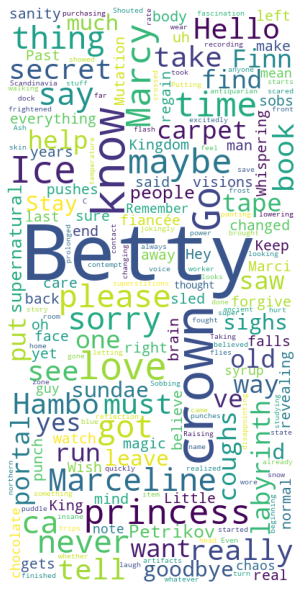

In [16]:
plot_character_wordcloud('Simon', df)

In [26]:
def get_empty_character(character, row):
    amt = 0
    control = False
    for line in row['text']:
        if character == line['origin']:
            control = True
    if control:
        print(row['season_number'], row['episode_number'])

for i in range(len(df)):
    get_empty_character("Princess", df.loc[i])


4 7
2 3


In [27]:
row = df.loc[((df['season_number'] == 2) & (df['episode_number'] == 3))]
text = row.text
print(row.title)
print(len(row.text.iloc[0]))

for line in text.iloc[0]:
    if line['origin'] == "Princess":
        print(line)



145    Loyalty to the King
Name: title, dtype: object
171
{'origin': 'Princess', 'text': 'Yoo hoo! Nice King, Nice King over here!'}


In [13]:
df = df.reset_index(drop=True)
columns = ["season_number", 'episode_number', 'episode_title', 'directors', 'writers', 'origin', 'line']
lines_dataframe = pd.DataFrame(columns=columns)

for i in range(len(df)):
    data = {}
    row = df.iloc[i]
    data['season_number'] = row['season_number']
    data['episode_number'] = row['episode_number']
    data['episode_title'] = row['title']
    data['directors'] = row['directors']
    data['writers'] = row['writers']
    for l in row['text']:
        data['origin'] = l['origin']
        data['line'] = l['text']
        new_data = pd.DataFrame([data])
        lines_dataframe = pd.concat([lines_dataframe, new_data], ignore_index=True)


lines_dataframe


season_number episode_number       episode_title  \
0                 1              3   Prisoners of Love   
1                 1              3   Prisoners of Love   
2                 1              3   Prisoners of Love   
3                 1              3   Prisoners of Love   
4                 1              3   Prisoners of Love   
...             ...            ...                 ...   
28328            10             13  Come Along With Me   
28329            10             13  Come Along With Me   
28330            10             13  Come Along With Me   
28331            10             13  Come Along With Me   
28332            10             13  Come Along With Me   

                                directors  \
0      [Larry Leichliter, Patrick McHale]   
1      [Larry Leichliter, Patrick McHale]   
2      [Larry Leichliter, Patrick McHale]   
3      [Larry Leichliter, Patrick McHale]   
4      [Larry Leichliter, Patrick McHale]   
...                                   ...   
28328  ["Cole Sanchez", "Diana Lafyatis"]   
28329  ["Cole Sanchez", "Diana Lafyatis"]   
28330  ["Cole Sanchez", "Diana Lafyatis"]   
28331  ["Cole Sanchez", "Diana Lafyatis"]   
28332  ["Cole Sanchez", "Diana Lafyatis"]   

                                                 writers  origin  \
0                            [Pendleton Ward, Adam Muto]  action   
1                            [Pendleton Ward, Adam Muto]    Finn   
2                            [Pendleton Ward, Adam Muto]  action   
3                            [Pendleton Ward, Adam Muto]    Finn   
4                            [Pendleton Ward, Adam Muto]  action   
...                                                  ...     ...   
28328  ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...    Beth   
28329  ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...  action   
28330  ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...    Beth   
28331  ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...  Shermy   
28332  ["Tom Herpich", "Steve Wolfhard", "Somvilay Xa...  action   

                                                    line  
0      [The episode starts with Finn and Jake sleddin...  
1      Oh, no, our sled's broken! Hey, let's build on...  
2                             [Jake grows to giant size]  
3                              What are you doing, Jake?  
4                                      [They both laugh]  
...                                                  ...  
28328                                       Very pretty.  
28329  [Shermy grunts as he trying to pull out the Fi...  
28330                           Lift that sword, Shermy.  
28331                            [He does so.] Oh, yeah!  
28332  [The Finn Sword shines under sunlight, ending ...  

[28333 rows x 7 columns]

In [14]:
file_name = 'lines.pkl'

# Salvar o DataFrame em disco usando pickle
with open(file_name, 'wb') as file:
    pickle.dump(lines_dataframe, file)